<h1><a id='outline'>Project Outline</a></h1>

* [Data Pre-Processing](#dpp)
  *  [Required Libraries](#libs)
  *  [Separate Data](#sep)
  *  [General Data Overview](#gdo)
* [Question 1](#rq1d)
  *  [Read in Q1 Data](#rq1d)
  *  [Quality Score Distribution](#sep)
  *  [Separate Data](#sep)
  *  [Question 1a](#q1a)
  *  [Question 1b Code](#q1bc)
  *  [Question 1b Answer](#q1ba)
  *  [Question 1c Code](#q1cc)
  *  [Question 1c Answer](#q1ca)
  *  [Question 1d](#q1d)
  *  [Question 1e](#q1e)
* [Question 2](#q2cc)
  * [Question 2 Code](#q2cc)
  * [Question 2 Answer](#q2ab)
  * [Question 2c](#q2c)
* [Question 3](#q3)
    * [Identify all the sites whose support for homozygosity is high](#q3)
    * [Aggregate the data](#q3g)
    * [Question 3a](#q3a)
      * [Estimate $\hat{P_q}$ for all q](#q3pq)
      * [Calculate $L(H_o |  Data )$ using $\hat{P}_{q}$ values](#q3lho)
      * [Estimate $\hat{P_{bq}}$ for all q and all true bases b](#q3pqb)
      * [Calculate $L(H_a |  Data )$ using $\hat{P}_{qb}$ values](#q3lha)
      * [Calculate the P-Val for the LRT](#q3pval)
    * [Question 3b](#q3b)
    

    
    
    
    

<h2><a id="dpp">Data prep and cursory analysis</a></h2>

<h4><a id="libs">Python Libraries and Jupyter Magic</a></h4>

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
# if the line above fails then in the command line type: conda install -c r rpy2; conda install tzlocal
#After installing restart your kernal by clicking Kernal -> restart
from pandas import Series
from collections import Counter
from Locus import *
from math import log
from os import chdir
from rpy2.robjects.packages import STAP
from rpy2.robjects.vectors import FloatVector as rArray
from scipy.stats import chi2
from sys import maxsize as MAXSIZE
import rpy2.rinterface
import pickle

chdir("/mnt/research/germs/shane/Classes/BCB_2_ComputationalStats/HW1") #comment this line out if you aren't Shane

#### Separate Data
<a id="sep"></a>
##### Divide the data by individual and position because github wont allow large files and this will allow us to only load small amounts of data into memory at a time

In [2]:
%%bash
cd data/
for individual in {0..2}; do 
    for pos in {764..1199}; do
        awk -v individual="$individual" -v pos="$pos" '($1==individual && $3==pos && $4!="NA") {print $0}' genotyping.txt > Individual$individual\_position$pos.txt
    done

#### General Data Overview 
<a id="gdo"></a>
<ol style="display: inline; padding: 0;margin-top: -10px;"> <p style="display: inline; padding: 0;margin-top: -10px;"><u>Genotyping.txt Column Designations:</u></p>
    <li>Id of individual</li>
    <li>Id of read</li>
    <li>Reference position</li>
    <li>Read base call</li>
    <li>Read quality score</li>
</ol>

In [4]:
%%bash 
head data/Individual0_position962.txt

0 0 962 A p
0 1 962 A h
0 2 962 A i
0 3 962 A l
0 4 962 G X
0 5 962 G p
0 6 962 G p
0 7 962 A p
0 8 962 A p
0 9 962 G r


[Project Outline](#outline)
### Question 1
##### Read in Q1 Data
<a id="rq1d"></a>

In [2]:
class SeqRead:
    def __init__(self,data):
        rec = data.strip().split()
        self.q = ord(rec[4]) - 33
        self.errorProb = 10.0**((-self.q)/10.0)
        self.call = rec[3]
        self.matchesRef = False
        
pos962,pos964 = [],[]
for line in open("data/Individual0_position962.txt"): pos962.append(SeqRead(line))
for line in open("data/Individual0_position964.txt"): pos964.append(SeqRead(line))
positions = [pos962,pos964]
data, all_qs, all_errors, all_calls = [],[],[],[]
for pos in positions:
    calls, errorProbs, qscores = [],[],[]
    for read in pos:
        qscores.append(read.q)
        errorProbs.append(read.errorProb)
        calls.append(int(read.call=='A'))
    all_calls.append(calls)   
    all_qs.append(qscores) 
    all_errors.append(errorProbs)
    qscores = Series(qscores)
    data.append(qscores)

##### Describe and plot the distribution of Q scores to see data quality
<a id="q1qc"></a>

Individual 0 Position 962 Quality score Distribution
 count    8883.000000
mean       71.602837
std        13.239879
min         3.000000
25%        71.000000
50%        78.000000
75%        80.000000
max        81.000000
dtype: float64


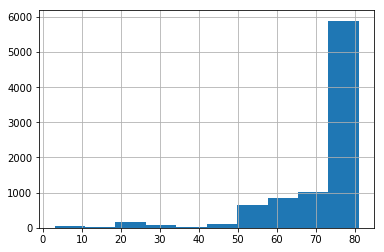

In [3]:
print("Individual 0 Position 962 Quality score Distribution\n",data[0].describe())
data[0].hist().plot();

Individual 0 Position 964 Quality score Distribution
 count    8886.000000
mean       75.660027
std         9.702624
min         3.000000
25%        77.000000
50%        80.000000
75%        80.000000
max        81.000000
dtype: float64


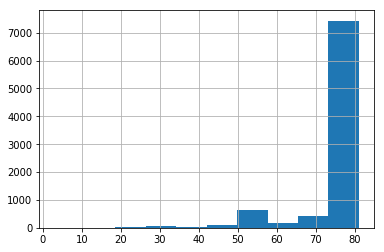

In [4]:
print("Individual 0 Position 964 Quality score Distribution\n",data[1].describe())
data[1].hist().plot();

[Project Outline](#outline)
<h5><a id='q1a'>Question 1a.</a></h5>

![](images/Q1A.png)

$L(g|Z_1,Z_2,...,Z_l)$ def $\stackrel{def}{=}$ $Pr(Z_1=z_1,Z_2=z_2,...,Z_l=z_l|G=g)$ 

$\stackrel{CP}{=}$ $\frac{Pr(Z_1=z_1 \cap Z_2=z_2 \cap...\cap Z_l=z_l\cap G=g)}{Pr(G=g)}$

$\stackrel{MR}{=}$ $\frac{1}{Pr(G=g)} * Pr(Z_1=z_1) * Pr(Z_2=z_2|Z_1=z_1) * Pr(Z_3=z_3|Z_1=z_1 \cap Z_2=z_2) * ... * Pr(Z_l=z_l | Z_1=z_1 \cap ... \cap Z_{l-1}=z_{l-1}) * Pr(G=g|Z_1=z_1 \cap ... \cap Z_l=z_l)$ 

Since G is independent of Z_n,

$Pr(G = g | Z_1=z_1  \cap ... \cap  Z_l=z_l)$ = Pr(G = g)

and Pr(G = g) cancels.

$\stackrel{Independance\: of \:reads}{=}$ $Pr(Z_1=z_1)Pr(Z_2=z_2)...Pr(Z_l=z_l)$

$\stackrel{WLOG}{=}$ ${\displaystyle \prod_{j=1}^{k} Pr(Z_j=1)}$ $\cdot$ ${\displaystyle \prod_{j=k+1}^{l} Pr(Z_j=0)}$

where $Z_j= \mathbb{1}\{D_j=b_r\}$ is an indicator function matching the read $b_r$ to the reference allele $D_j$. A read either matches the reference $Z_j = 1$ or it doesn't $Z_j = 0$

##### From the class lecture notes we know that Li makes the assumption that the probability of an error in observing a particular call in a read at a specific site is equal to $10^{-(ord(q)-33)/10}$ where q is the quality score of the read from the sequencer, which is recorded in the fastq file. So, the probability of an error $10^{-(ord(q)-33)/10}$ = $e_{ijs}$


![](images/Tree.jpeg)

Given that we are dealing with a diploid, we have to adjust the probability of an error for the read by the ploidy.

Using the picture above we substituted the $Pr(Z_j = 0)$ and $Pr(Z_j = 1)$ with their respective tree combinations of the probility of having a success or failure to come up with the final equation mapping the probability of a genotype at a position given the reads at observed at that position.

[Project Outline](#outline)
<h5>Question 1b.</h5>
&nbsp; Use the data from three diploids at https://dorman.stat.iastate.edu/files/genotyping.txt to compute the likelihood of the data in individual 0 at sites 962 and 964 assuming the reference base in both cases is $n_{b}$ = A. What are your maximum likelihood estimates $\hat{G}_{MLE,962}$ and $\hat{G}_{MLE,964}$ of the genotypes? (These data are unforgivingly huge, so you may want to do selective reading of the data in some smart way.)</p>
<br/>
<h5><a id='q1bc'>Question 1b Code</a></h5>
<h6> The code below (written by me) is taking the stored R functions in the file Q1_MLE.R (modified from the <a href="">R code in the class notes</a>) and converting it to python functions which I then call. For your convenience I have displayed the function being used in R magic, though the R magic cell doesn't actually do anything.</H6>

In [31]:
with open('Q1_MLE.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")

In [5]:
%%R
log.likelihood.d.g <- function(genotype, calls, ploidy, errorProbs, coverage){
  -coverage*log(ploidy) +
  sum(
      log(
          ifelse(  calls == 1, 
                   genotype * (1 - errorProbs) + (ploidy - genotype) * errorProbs/3, 
                   (1 - errorProbs) * (ploidy - genotype) + genotype * errorProbs + (2*errorProbs*(ploidy-genotype))/3 
                 )
          )
      )
}

In [4]:
for pos in range(0,2):
    print("Finding MLE:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_d_g(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

Finding MLE:
-6152.268491224305 1
Finding MLE:
-6160.344705015218 1


<h5>Question 1b Answer</h5>
The results above show that $\hat{G}_{MLE,962}$ = 1, given that the max of the likelihood function is -6152.268. $\hat{G}_{MLE,964}$ is also equal to 1 with the max of the likelihood function of -6160.3447.

<h5>Question 1c</h5>
Now find the maximum a posterior estimates $\hat{G}_{MAP,962}$ and $\hat{G}_{MAP,964}$ and explain any additional assumptions you make.
<h5><a id='q1cc'>Question 1c Code</a></h5>

In [9]:
%%R
log.likelihood.MAP <- function(g, a, m, e, k){
  -k*log(m) + log(0.5) +
    sum(
        log(
            ifelse(  a == 1, 
                     g * (1 - e) + (m - g) * e/3, 
                     (1 - e) * (m - g) + g * e + (2*e*(m-g))/3
                  )
        )
    )
}

In [ ]:
def MatchesRefMLE(df,g,m,k):
    
    
    

In [6]:
for pos in range(0,2):
    print("Finding MAP:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_MAP(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

Finding MAP:
-6152.961638404865 1
Finding MAP:
-6161.037852195778 1


<h4><a id='q1ca'>Question 1c Answers</a></h4>
$\hat{G}_{MAP,962}$ and $\hat{G}_{MAP,964}$ are both one. We assumed a prior $P(G = g)$ of .5. We chose this value because our null hypothesis is that the individual these reads came from is homozygous reference. Having no knowledge of the reference allele, we chose .5 because the position is either a SNP or not a SNP, so one of 2 possibilities. We could have chose many other priors, but since $P(G = g)$ only scales the maximum likelihood, any value we put would give us the same result.

<h4><a id='q1d'>Question 1d</a></h4>

##### What is your confidence in the MAP estimates? Provide a numeric measure of that confidence.

Using the code below. we attempted to get a numerical estimate by using Asymptotic Confidence Intervals as described in the SNP calling notes from class. However, when we implemented the functions we (I) must have done something wrong with the derivations because for both we get a pval of 0, which is about what we would expect given that the data shows that there is a SNP there. From further searching I see that we were supposed to use the likelihood of \psi but we ran out of time to make it work. 

In [55]:
from scipy.stats import chi2
Ls = rfuncts.log_likelihood_gmap("data/Pos962_data.txt")
L_Ho = float(Ls[2])
print (L_Ho)
L_Ha = min(float(Ls[0]),float(Ls[1]))
print (L_Ha)
Lambda = L_Ho/L_Ha
print(Lambda)
lambd = -2*log(Lambda)
print("lambda:",lambd)
print(chi2.pdf(lambd,1))
print("\n")

Ls = rfuncts.log_likelihood_gmap("data/Pos964_data.txt")
L_Ho = float(Ls[2])
print (L_Ho)
L_Ha = min(float(Ls[0]),float(Ls[1]))
print (L_Ha)

Lambda = L_Ho/L_Ha
print(Lambda)
lambd = -2*log(Lambda)
print("lambda:",lambd)
print (chi2.pdf(lambd,1))


-83316.69248101514
-67592.65415952701
1.2326293961526864
lambda: -0.4182992163208919
0.0


-89699.69855779826
-69222.3349671043
1.2958201800101827
lambda: -0.5182876766225387
0.0


In [30]:
for fileName in ["data/Pos962_data.txt","data/Pos964_data.txt"]:
    psi = rfuncts.estimate_psi(fileName)[0]

0.49999968218679913
0.49999968218679913


<h4><a id='q1e'>Question 1e</a></h4>

##### You should always look at your data and numeric summaries of it to make sure the data are consistent with assumptions your model is making. Do you see anything unusual in the data from these two sites? Are your conclusions and confidence affected?

No, we already took a look at the data and 1 seems like a good estimate for the parameter G given that there appears to be a roughly equal number of A's and G's. Based on the quality score graphs I showed above we have really high quality reads so our answers wouldn't change.

<h3>Question 2</h3>
&nbsp; <p><b>a.</b>Produce a space-separated text file with the individual in set{0,1,2}, the site in set{764,765,...,1199}, and the p-value for rejecting H0. For computing the p-value, use Monte Carlo sampling to estimate</p>
<h4><a id='q2cc'>Question 2 Code</a></h4>

##### Python Helper classes and functions

In [7]:
from collections import Counter     
class Locus:
    def __init__(self,pos):
        self.majorAllele = None
        self.majorAlleleCount = -1
        self.qscores = {0:[],1:[],2:[]}
        self.errorProbs = {0:[],1:[],2:[]}
        self.reads = {0:[],1:[],2:[]}
        self.callMatchRef = {0:[],1:[],2:[]}
        nuc_counter = {'A':0, 'C':0, 'G':0, 'T':0}
        self.read_counter = {0:nuc_counter.copy(),    1:nuc_counter.copy(),    2:nuc_counter.copy()}
        self.total_reads = {0:0,1:0,2:0}
        
    def __iter__(self):
        for key in self.qscores.keys():yield key
            
    def add(self,line,individual):
        if line != "":
            read = SeqRead(line)
            self.reads[individual].append(read)
            self.errorProbs[individual].append(read.errorProb)
            self.read_counter[individual][read.call] += 1
            self.total_reads[individual] += 1

    def calcMajorAllele(self):
        totals = {}
        for base in ['A','C','G','T']:
            for i in range(0,3):
                try: totals[base] += self.read_counter[i][base]
                except: totals[base] = self.read_counter[i][base]
        totals = Counter(totals)
        self.majorAllele, self.majorAlleleCount = totals.most_common(1)[0] 
        
        for ind in self:
            for read in self.reads[ind]:
                self.callMatchRef[ind].append(int(read.call == self.majorAllele))
#                 self.qscores[ind].append(read.q)
        
def ProcessPosition(pos):
    curLocus = Locus(pos)
    i_0_file = "data/Individual0_position%i.txt" % pos
    i_1_file = "data/Individual1_position%i.txt" % pos
    i_2_file = "data/Individual2_position%i.txt" % pos
    for line in open(i_0_file): curLocus.add(line,0)
    for line in open(i_1_file): curLocus.add(line,1)
    for line in open(i_2_file): curLocus.add(line,2)
    curLocus.calcMajorAllele()
    return curLocus        

  #### R functions and R Coversion helper object

In [4]:
from rpy2.robjects.packages import STAP
from rpy2.robjects.vectors import FloatVector as rArray
with open('Q2_DPBinomial.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")

In [1]:
import datetime
from scipy.stats import bernoulli
rbern=bernoulli.rvs 
import time
nsims = 1000
output = open("Question2.txt","w")
output.write("Individual Pos MC-PVal PA-Pval NA-PVal BA-PVal MCBN-PVal\n")
output.close()
data=None
failed, totalRuns = 0, 0
for pos in range(764,764):
    print( str(datetime.datetime.now()).split('.')[0])
    print(pos)
    data = ProcessPosition(pos)
    for individual in data:
        print(individual,pos,data.read_counter[individual],)
        if data.total_reads[individual] == 0: #if there are no reads for that individual at that position
            #output.write("%i %i %0.4f %0.4f %0.4f %0.4f %0.4f\n" % (individual,pos,0.0,0.0,0.0,0.0,0.0))
            continue
        successfulTrials = 0
        refAllele = data.majorAllele
        for sim in range(nsims):
            numMatchesRef = 0
            for read in data.reads[individual]:
                #randomDraw = bern random (1-eij,1)
                rdraw = rbern(1 - read.errorProb, size=1)[0]
                numMatchesRef += rdraw
            if numMatchesRef <= data.read_counter[individual][refAllele]: successfulTrials+=1
            else: failed+=1
            totalRuns+=1
        MC_PVal   = successfulTrials/float(nsims)
        PA_Pval   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="PA")[0]
        NA_PVal   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="NA")[0]
        BA_PVal   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="BA")[0]
        MCBN_PVal = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="MC")[0]
        #outString = "\t".join([str(individual),str(pos),"%0.8f" % MC_PVal,"%0.8f" % PA_Pval,"%0.8f" % NA_PVal,"%0.8f" % BA_PVal,"%0.8f" % MCBN_PVal,str(data.read_counter[individual],)])
        #output.write(outString+"\n")
        output = open("Question2.txt","a")
        output.write("%i %i %0.4f %0.4f %0.4f %0.4f %0.4f\n" % (individual,pos,MC_PVal,PA_Pval,NA_PVal,BA_PVal,MCBN_PVal))
        output.close()
output.close() 

<h4><a id='q2ab'>Question 2 A and B Answer Sample</a></h4>

In [9]:
%%bash
head Question2_output.txt
tail Question2_output.txt

Individual Pos MC-PVal PA-Pval NA-PVal BA-PVal MCBN-PVal
0 1000 0.0000 0.4502 0.0000 0.0000 0.0000
1 1000 0.0000 0.4338 0.0000 0.0000 0.0000
2 1000 0.0000 0.0000 0.0000 0.0000 0.0000
0 1001 0.0000 0.0004 0.0000 0.0000 0.0000
1 1001 0.0000 0.0001 0.0000 0.0000 0.0000
2 1001 0.0000 0.0000 0.0000 0.0000 0.0000
0 1002 0.0000 0.3759 0.0000 0.0000 0.0000
1 1002 0.0000 0.3815 0.0000 0.0000 0.0000
2 1002 0.0000 0.4128 0.0000 0.0000 0.0000
2 996 0.0000 0.4445 0.0000 0.0000 0.0000
0 997 0.1820 0.4891 0.1371 0.2498 0.0725
1 997 0.0000 0.4615 0.0001 0.0103 0.0001
2 997 0.0000 0.4368 0.0000 0.0000 0.0000
0 998 0.0000 0.4054 0.0000 0.0000 0.0000
1 998 0.0000 0.4070 0.0000 0.0000 0.0000
2 998 0.0000 0.3695 0.0000 0.0000 0.0000
0 999 0.0000 0.4496 0.0000 0.0000 0.0000
1 999 0.0000 0.4745 0.0000 0.0019 0.0000
2 999 0.0000 0.3575 0.0000 0.0000 0.0000


[Project Outline](#outline)
<h4><a id='q2c'>Question 2c</a></h4>
For the most part I believe the results make sense. When we se a lot of reads that are all the same base we get 0 or close to 0. When there is a clear het, we get larger p values. The poison method appear to never have significant pvalues. The closest distribution to our monte carlo sampling mimicing a poisson binomail is the monte carlo simulation using a binomail.

[Project Outline](#outline)
<h1><a id='q3'>Question 3</a></h1>
<h4>Identify all the sites whose support for homozygosity is high</h4>

In [2]:
with open('Q1_MLE.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")
Gmaps = set()
remove=set()
#for each position in the data
for pos in range(764,1200):
    #1. Read the data for all 3 individuals at that position
    data = ProcessPosition(pos)
    #If there are no reads for an individual don't consider the position
    if data.total_reads[0] == 0 or data.total_reads[1] == 0 or data.total_reads[2] == 0:
        remove.add(pos)
        continue

    #2. For each individual
    for ind in [0,1,2]:
        #Determine G=2 Log likelihood
        maxScore = rfuncts.log_likelihood_MAP(2,rArray(data.callMatchRef[ind]),2,rArray(data.errorProbs[ind]),data.total_reads[ind])[0]
        
        #Check to make sure G=1,0 are not bigger than G=2. If they are, remove position pos from being a homozygous position
        gIs2 = True
        for g in range(1,0,-1):
            L = rfuncts.log_likelihood_MAP(g,rArray(data.callMatchRef[ind]),2,rArray(data.errorProbs[ind]),data.total_reads[ind])[0]
            if maxScore < L: 
                gIs2 = False
                remove.add(pos)
                break
        if gIs2: Gmaps.add(pos)

homozygousPositions = Gmaps.difference(remove)
pickle.dump(homozygousPositions,open("homoPos.p","wb"))
print("Total number of positions where all individuals are homozygous:",len(homozygousPositions))

Total number of positions where all individuals are homozygous: 43


In [3]:
homozygousPositions = pickle.load(open("homoPos.p","rb"))

<h4><a id="q3g">Group by TrueBase then by read call then by q</a></h4>

In [3]:
all_reads = {'A':{},'C':{},'G':{},'T':{}}  #{trueBase:{readCall:{q:count}}}
all_qs = set()
for pos in homozygousPositions:
    print(pos,end=" ")
    data = ProcessPosition(pos)
    ma = data.majorAllele
    for ind in data:
        for read in data.reads[ind]:
#             if read.q == 2:
#                 print(read.call,ma)
            all_qs.add(read.q)
            try: all_reads[ma][read.call][read.q] +=1
            except: 
                try:all_reads[ma][read.call][read.q] = 1
                except: all_reads[ma][read.call] = {read.q:1}
pickle.dump(all_reads,open("aggregatedByMatchRefData.p","wb"))       
pickle.dump(all_qs,open("all_qs.p","wb"))  

1028 1031 1033 907 908 1042 915 1048 921 1055 1056 930 932 935 942 952 955 956 957 958 961 965 966 967 970 972 977 980 983 986 991 993 996 997 998 999 1002 1005 1006 1007 1008 1011 1021 

In [4]:
all_reads = pickle.load(open("aggregatedByMatchRefData.p","rb"))
all_qs = pickle.load(open("all_qs.p","rb"))

<h2>Question 3a</h2>
<h4><a id="q3pq">Estimate $\hat{P_q}$ for all q</a></h4>

In [6]:
print("Number of Q values:",len(all_qs))

bases = set(['A','C','G','T'])
Phat_q = {}
Q_matchingCounts = {}
for q in all_qs:
    totalReads = 0
    notMatching = 0
    for trueBase, calls in all_reads.items():
        #Reads that match the ref base and Q=q
        if q in all_reads[trueBase][trueBase]: totalReads += all_reads[trueBase][trueBase][q] 
            
        #Reads that don't match the ref base and have Q=q
        for readBase in bases.difference(set([trueBase])):
            try: 
                notMatching += all_reads[trueBase][readBase][q]
                totalReads  += all_reads[trueBase][readBase][q]
            except:continue #Do nothing there are no reads with that base or that quality
            #print ("\t",q,refBase,base,all_reads[refBase][base][q])
    
    Q_matchingCounts[q] = [totalReads-notMatching,notMatching]  # {q:[#reads with Q=q and match ref, #reads with Q=q and do NOT match ref]}
    phat_q = notMatching/float(totalReads)
    #print ("P_%i = %i / %i = %.8f" % (q,notMatching,totalReads,phat_q))
    Phat_q[q] = phat_q #Store p-hat_q %
pickle.dump(Phat_q,open("Phat_q.p","wb")) 
pickle.dump(Q_matchingCounts,open("Q_matchingCounts.p","wb")) 

Number of Q values: 80


In [2]:
Phat_q = pickle.load(open("Phat_q.p","rb")) 
Q_matchingCounts = pickle.load(open("Q_matchingCounts.p","rb")) 

<h4><a id="q3lho">Plug all $\hat{P}_{q}$ into the $L(H_o |  Data )$</a></h4>

In [8]:
L_H_o = 0.0
nparamsHo = 0
for q in all_qs:
    nparamsHo += 1
    if Phat_q[q] == 0:
        L_H_o -= MAXSIZE
    else:
        notError = Q_matchingCounts[q][0]*log(1-Phat_q[q])
        error = Q_matchingCounts[q][1]*log(Phat_q[q])        
        L_H_o +=  (notError + error)
    #print("Q=%i (1-%.8f)^%i * (%.8f)^%i" % (q,Phat_q[q],Q_matchingCounts[q][0],Phat_q[q],Q_matchingCounts[q][1]))
print(L_H_o)

-1.8446744073709564e+19


#### Now Lets work on the $L(H_A)$

![](images/Ha.jpeg)

<h4><a id="q3pbq">Estimate the $\hat{P}_{bq}$ values</a></h4>

In [9]:
P_QBs = {}
P_QB_Counts = {}
for trueBase in bases:
    P_QBs[trueBase] = {}
    P_QB_Counts[trueBase] = {}
    for q in all_qs:
        total_with_q = 0
        dont_Match_True_Base = 0 
        
        if q in all_reads[trueBase][trueBase]:total_with_q = all_reads[trueBase][trueBase][q]
        for readBase in bases.difference(set([trueBase])):
            if q in all_reads[trueBase][readBase]:
                dont_Match_True_Base += all_reads[trueBase][readBase][q]
                total_with_q += all_reads[trueBase][readBase][q]
        try:
            P_QBs[trueBase][q] = dont_Match_True_Base / float(total_with_q)
            P_QB_Counts[trueBase][q] = [total_with_q-dont_Match_True_Base,dont_Match_True_Base]
        except: pass
            #print (dont_Match_True_Base,total_with_q)
pickle.dump(P_QB_Counts,open("P_QB_Counts.p","wb")) 
pickle.dump(P_QBs,open("P_QBs.p","wb")) 

In [7]:
P_QB_Counts = pickle.load(open("P_QB_Counts.p","rb")) 
P_QBs = pickle.load(open("P_QBs.p","rb")) 

<h4><a id="q3lha">Plug all $\hat{P}_{qb}$ into $L(H_a |  Data )$</a></h4>

In [10]:
L_H_a = 0.0
nparamsHa = 0
for base in P_QBs:
    for q in P_QBs[base]:
        nparamsHa += 1
        #print ("P_%s%i = (%i * log(1-%.8f) + %i * log(%.8f))" % (base, q, P_QB_Counts[base][q][0], P_QBs[base][q], P_QB_Counts[base][q][1], P_QBs[base][q]))
        if P_QBs[base][q] == 0:
            L_H_a -= MAXSIZE
        else:
            L_H_a += P_QB_Counts[base][q][0]*log(1-P_QBs[base][q]) + P_QB_Counts[base][q][1]*log(P_QBs[base][q])

print(L_H_a)

-4.611686018427388e+20


<h4><a id="q3pval">Calculate the $P_{val}$ for the LRT</a></h4>

In [11]:
print("lambda",L_H_o/L_H_a)
print("Lambda:",-2*log(L_H_o/L_H_a))
print("P-Val:",1-chi2.cdf(-2*log(L_H_o/L_H_a),nparamsHa-nparamsHo))

lambda 0.04000000000000003
Lambda: 6.4377516497364
P-Val: 1.0


<h2><a id="q3b">Question 3b</a></h2>
$\hspace{10mm}$ 
$\frac{L_0}{L_1} =$ 
$\hspace{10mm}$ 
$\frac{{\displaystyle \prod_{i=1}^{3}}{\displaystyle \prod_{j=1}^{l_i}}{\displaystyle \prod_{k=1}^{m_i}} (1-\hat{p}_{q_{ijk}})^{\mathbb{1}\{R_{ijk}=b_{k}\}}(\hat{p}_{q_{ijk}})^{\mathbb{1}\{R_{k} \neq b_{ijk}\}}}{{\displaystyle \prod_{X=1}^{93}}{\displaystyle \prod_{i=1}^{3}}{\displaystyle \prod_{j=1}^{l_i}}{\displaystyle \prod_{k=1}^{m_i}}[(1-\hat{p}_{b'_kq_{ijk}})^{\mathbb{1}\{R_{ijk}=b_k\}}(\hat{p}_{b'_kq_{ijk}})^{\mathbb{1}\{R_{ijk} \neq b_k\}}]^{{\mathbb{1}\{Q=X\}}}}$

<br></br>

$\prod_{i=1}^{q} (1-P_q)^{\#match}*(P_q)^{\# no match}$


In [12]:
P_QB_Primes = {}
bases = set(['A','C','G','T'])
P_QB_Prime_Counts = {}
for trueBase in bases:
    P_QB_Primes[trueBase] = {}
    P_QB_Prime_Counts[trueBase] = {}
    for q in all_qs:
        total_with_q = 0
        if q in all_reads[trueBase][trueBase]:total_with_q = all_reads[trueBase][trueBase][q]
        mismatchCounter={}  
        for readBase in bases.difference(set([trueBase])):
            if q in all_reads[trueBase][readBase]:
                mismatchCounter[readBase] = all_reads[trueBase][readBase][q]
                total_with_q += all_reads[trueBase][readBase][q]
            else: mismatchCounter[readBase] = 0.0
        if total_with_q == 0: continue        
        for base,mismatchCount in mismatchCounter.items():
            try:
                P_QB_Primes[trueBase][q][base] = mismatchCount / float(total_with_q)
                P_QB_Prime_Counts[trueBase][q][base] = [total_with_q - mismatchCount, mismatchCount]
            except:
                P_QB_Primes[trueBase][q] = {base:mismatchCount / float(total_with_q)} 
                P_QB_Prime_Counts[trueBase][q] = {base:[total_with_q - mismatchCount, mismatchCount]}      

In [14]:
L_H_o = 0.0
nparamsHo = 0
for q in all_qs:
    nparamsHo += 1
    if Phat_q[q] == 0: #pass
        L_H_o -= MAXSIZE
    else:
        notError = Q_matchingCounts[q][0]*log(1-Phat_q[q])
        error = Q_matchingCounts[q][1]*log(Phat_q[q])        
        L_H_o +=  (notError + error)
    #print("Q=%i (1-%.8f)^%i * (%.8f)^%i" % (q,Phat_q[q],Q_matchingCounts[q][0],Phat_q[q],Q_matchingCounts[q][1]))
print(L_H_o)

-1.8446744073709564e+19


In [15]:
L_H_a = 0.0
nparamsHa = 0
for trueBase in P_QB_Primes:
    for q in P_QB_Primes[trueBase]:
        for readBase, mmCount in P_QB_Primes[trueBase][q].items():
            nparamsHa += 1
            #print("Q=%i (1-%.8f)^%i * (%.8f)^%i" % (q,P_QB_Primes[trueBase][q][readBase],P_QB_Prime_Counts[trueBase][q][readBase][0],P_QB_Primes[trueBase][q][readBase],P_QB_Prime_Counts[trueBase][q][readBase][1]))
            if P_QB_Primes[trueBase][q][readBase] == 0.0: #pass
                L_H_a -= MAXSIZE
            else:
                notError = P_QB_Prime_Counts[trueBase][q][readBase][0] * log(1-P_QB_Primes[trueBase][q][readBase])
                error =    P_QB_Prime_Counts[trueBase][q][readBase][1] * log(P_QB_Primes[trueBase][q][readBase])
                L_H_a +=  (notError + error)
print(L_H_a)

-4.1412940445477943e+21


In [16]:
print("lambda",L_H_o/L_H_a)
print("Lambda:",-2*log(L_H_o/L_H_a))
print("P-Val:",1-chi2.cdf(-2*log(L_H_o/L_H_a),nparamsHo))

lambda 0.004454342984409803
Lambda: 10.827751414364617
P-Val: 1.0


<h1><a id="q3c">Question 3c</a></h1>

In [17]:
qCount = {}
for q in all_qs:
    qDontMatch = 0
    qMatches = 0
    for trueBase in all_reads:
        if q in all_reads[trueBase][trueBase]: qMatches += all_reads[trueBase][trueBase][q]
        for readBase in bases.difference(set([trueBase])):
            if q in all_reads[trueBase][readBase]:
                qDontMatch += all_reads[trueBase][readBase][q]
    qCount[q] = [qMatches, qDontMatch]

In [23]:
L_H_o = 0.0
L_H_a = 0.0
for q in all_qs:
    L_H_o += qCount[q][0] * log(1-10**(-q/10)) + qCount[q][1] * log((1/3)*(10**(-q/10)))
    if Phat_q[q] == 0.0: L_H_a -= MAXSIZE
    else: L_H_a += qCount[q][0] * log(1-Phat_q[q]) + qCount[q][1] * log(Phat_q[q])
    
print("lambda",L_H_o/L_H_a)
print("Lambda:",-2*log(L_H_o/L_H_a))
print("P-Val:",1-chi2.cdf(-2*log(L_H_o/L_H_a),nparamsHo))

lambda 2.751807645001757e-15
Lambda: 67.05303674744155
P-Val: 0.8487676211840466
